In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

from importlib import reload # Python 3

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import datasource, trainutils, pytorchutils, pytorchnet

plt.rcParams['image.cmap'] = 'Set1'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
   
imwidth = 256
imheight = 256
numimgs = 500
numClasses=2   

learningRate=1e-4
trainSteps=500
batchSize=20
filters=(4, 8, 16, 32, 64)
strides=(2, 2,  2,  2)
resunits=1
kernelsize=3

1.0.1


float32 (500, 256, 256, 1) int32 (500, 256, 256)
float32 (1, 1, 256, 256) int32 (1, 1, 256, 256)


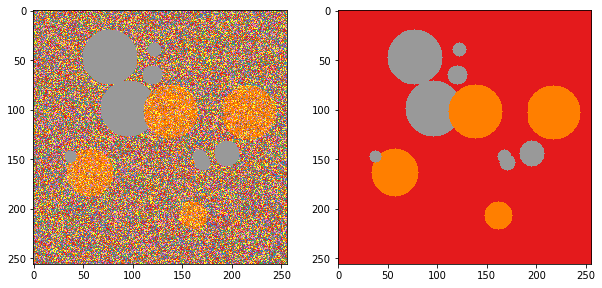

In [2]:
dataset=[trainutils.createTestImage(imwidth,imheight,noiseMax=1.0,numSegClasses=numClasses) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

print(imgin.dtype,imgin.shape,maskin.dtype,maskin.shape)
src=datasource.DataSource(imgin,maskin,augments=[pytorchutils.convertAug])

with src.threadBatchGen(1) as gen:
    im,msk=gen()
    
print(im.dtype,im.shape,msk.dtype,msk.shape)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(im[0,0])
ax[1].imshow(msk[0,0])

In [3]:
class UnetMgrNB(pytorchutils.SegmentMgr,trainutils.JupyterThreadMonitor):
    def __init__(self,net,src,batchSize,trainSteps):
        trainutils.JupyterThreadMonitor.__init__(self)
        pytorchutils.SegmentMgr.__init__(self,net)
        self.src=src
        self.batchSize=batchSize
        self.trainSteps=trainSteps
        
    def run(self):
        with self.src.threadBatchGen(self.batchSize) as gen:
            self.train(gen,self.trainSteps,1,10)
        
    def updateStep(self,step,steploss):
        self.updateGraphVals({'loss':steploss},('loss',))
        
        if step<10 or step%5==0:
            images,segs=self.traininputs
            logits,preds=self.netoutputs

            image=self.toNumpy(images[0,0])
            seg=self.toNumpy(segs[0,0])
            logit=self.toNumpy(logits[0].sum(0))
            pred=self.toNumpy(preds[0])
            
            imgmap=OrderedDict([
                ('Image',image),
                ('Seg',seg),
                ('Logit',logit),
                ('Pred',pred),
                ('Diff',np.dstack([seg>0,(seg>0)*(seg==pred),pred>0]).astype(np.float32)),
            ])
            
            self.updateImageVals(imgmap)

net=pytorchnet.Unet(1,numClasses+1,filters,strides,kernelsize)

mgr=UnetMgrNB(net,src,batchSize,trainSteps)

mgr.start()

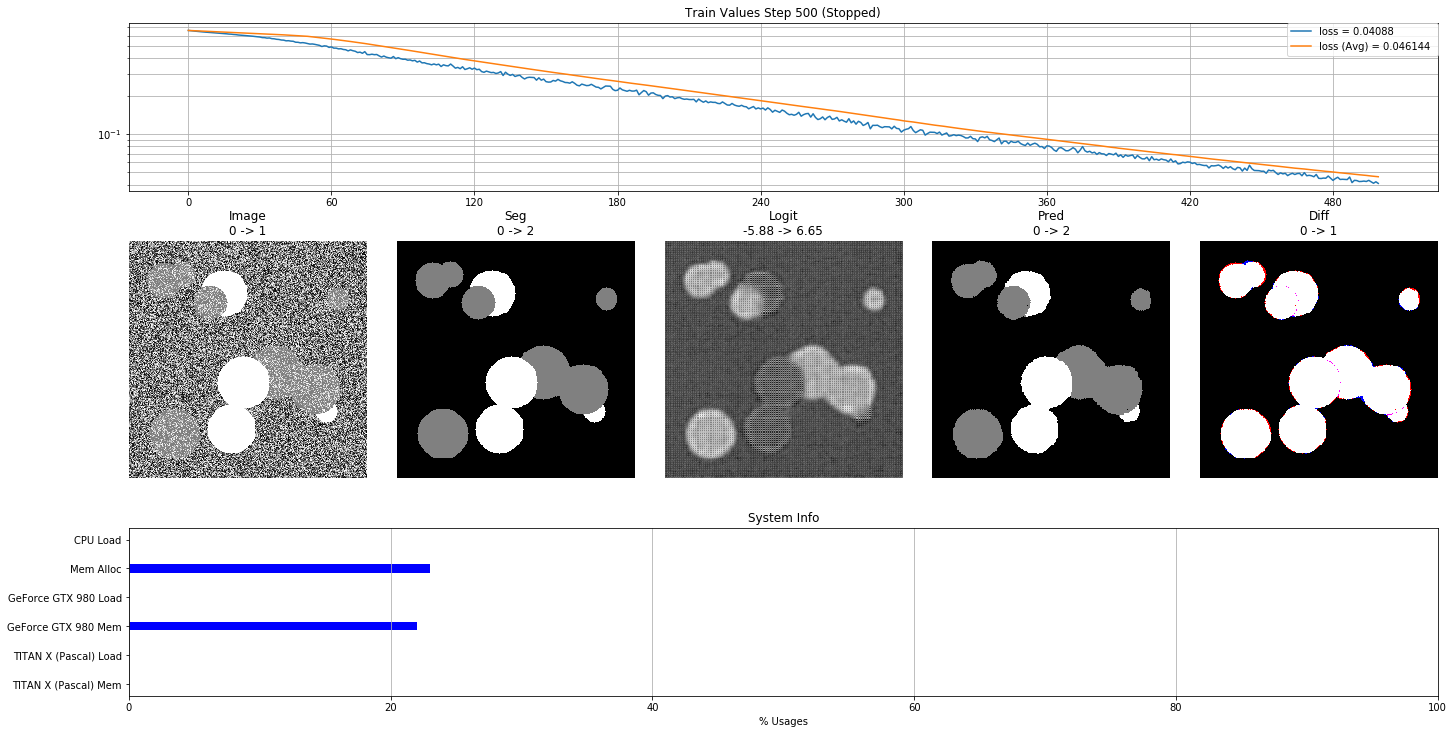

In [4]:
mgr.displayMonitor()

In [5]:
resnet=pytorchnet.Unet(1,numClasses+1,filters,strides,kernelsize,numResUnits=resunits)

resmgr=UnetMgrNB(resnet,src,batchSize,trainSteps)

resmgr.start()

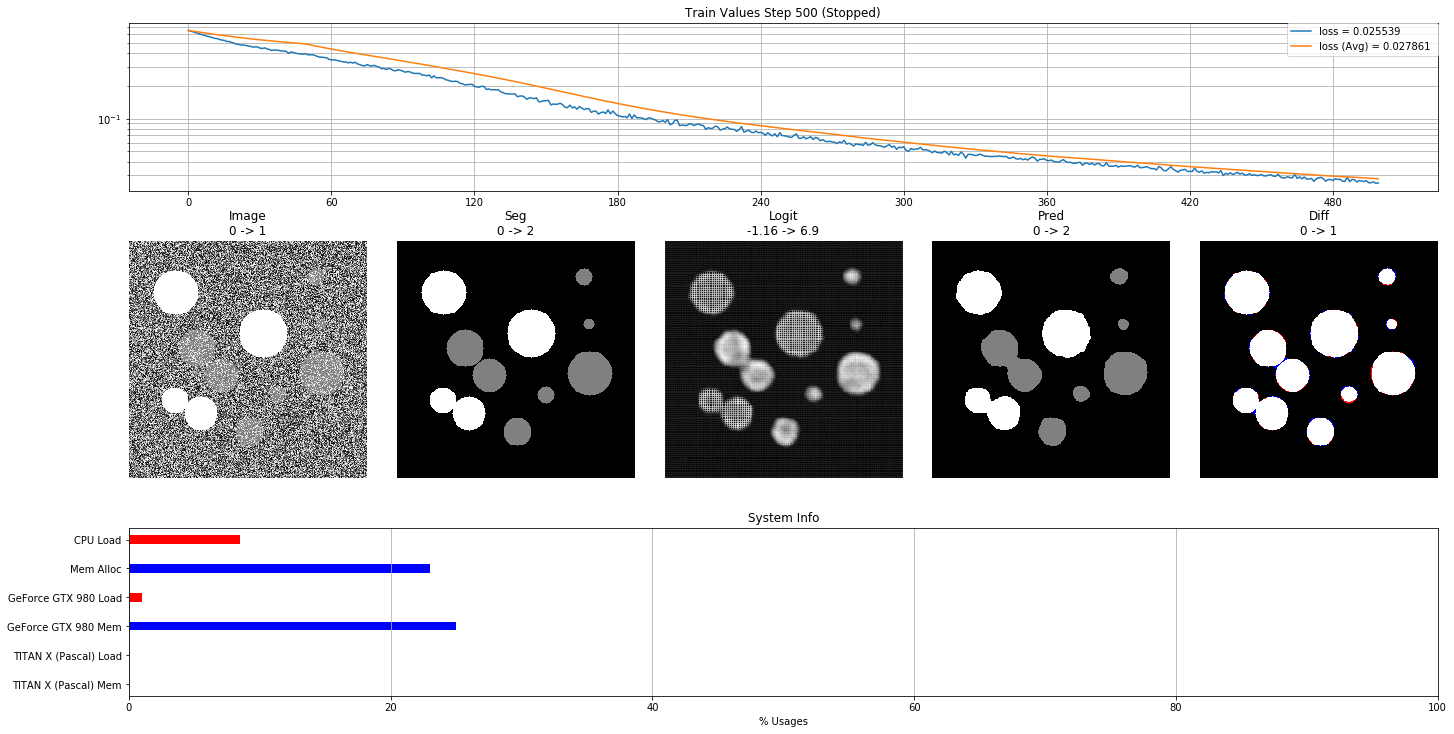

In [6]:
resmgr.displayMonitor()